In [15]:
#Imports
import torch
import os
import torchvision
import gc
import torchvision.datasets as dset
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
from torch import optim
from torch.autograd import Variable
from IPython.display import HTML
from zipfile import ZipFile
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch import autograd
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

In [16]:
#In Ordner ablegen
#Ordner wird erstellt
os.makedirs('dataDCGAN')
#Dateien werden entpackt nach Ordner
with ZipFile('anime-faces.zip', 'r') as f:
  f.extractall('dataDCGAN')

In [17]:
#Haupteingaben
#Batch-Größe
batch_size = 64

#Anzahl der Epochen
epoch_nr = 200

#Learning Rate
learning_rate = 0.0001

#GPUs die zur verwendung stehen (Optional)
ngpu = 1

In [18]:
#GPU wählen, wenn verfügbar
dv = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [19]:
#DataLoader
#Datenpfad wird angegeben (Ordner wurde zuvor erstellt, Daten wurden via Kaggle herunter geladen)
data_path = "dataDCGAN"

#Datenset erstellt
dataset = dset.ImageFolder(root=data_path,
                           transform=transforms.Compose([                               #Mehrere Transformationen am Datenset werden zusammen vorgenommen
                               transforms.Resize(64),                                   #Eingegebene Bildaten werden auf die entsprechende Größe gebracht
                               transforms.CenterCrop(64),                               #Schneidet das Bild zu, ausgehend von der Bildmitte
                               transforms.ToTensor(),                                   #Bilddateien werden zu Tensor konvertiert 
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  #Tensoren werden normalisiert (Kanal, Weite, Höhe)
                           ]))

#Dataloader wird erstellt
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [20]:
#Randomisierte Initialisierung der Gewichte
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
#Klassenerstellung Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #Eingebae eines z_vectors zum Auffalten
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            #Normalisierung
            nn.BatchNorm2d(512),
            #ReLu-Aktivierungsfunktion für Nichtlinearität
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #Zielgröße 64 erreicht
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            #Ausgabe von 3 Kanälen, da es sich um eine RGB Bilddatei handelt
            #Tanh-Aktivierungsfunktion für einen Wert zwischen [-1;+1]
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [22]:
#Initialiserung des Generators
gene = Generator(ngpu).to(dv)
#Randomisiert initialisierte Gewichte werden auf den Generator angewandt
gene.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [23]:
#Klassenerstellung Discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #Eingebae eines der drei RGB-Kanäle zum Auffalten ab der Bildgröße
            #LeakyReLu-Aktivierungsfunktion für Nichtlinearität, vermindert sterbende Neuronen
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            #Normalisierung 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            #Sigmoid-Aktivierungsfunktion, da binäre Klassifikation benötigt
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
#Initialisierung des Discriminators
disc = Discriminator(ngpu).to(dv)
#Randomisiert initialisierte Gewichte werden auf den Discriminator angewandt
disc.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [25]:
#Loss und Optimizer erstellen
#BCE wird als Loss festgelegt, misst den Binary Cross Entropy Loss zwischen Zielwert und Ausgabewert
#Binäre Aktivierungsfunktion wird benötigt
loss_function = nn.BCELoss()

#Feste Batch-vectoren definieren um den Generator-fortschritt im Bezug auf den Anfang festzustellen
fixed_noise = torch.randn(64, 100, 1, 1, device=dv)

#Optimizer für den Diskriminator wird festgelegt
#Algorithmus berechnet einen exponentiellen gleitenden Durchschnitt des Gradienten und des quadrierten Gradienten, Parameter steuern die Abklingraten
disc_optimizer = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
#Optimizer für den Generator wird festgelegt
gene_optimizer = optim.Adam(gene.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [26]:
#Trainingsschleife
#Ordner wird erstellt
os.makedirs('savesDCGAN')

#Arrays für Bilder, Generator & Diskriminator - Losses
img_list = []
gene_losses = []
disc_losses = []
iters = 0
safe = 0

#Schleife für Wiederholung nach Anzahl der Epochen
for epoch in range(epoch_nr):
    #Schleife für jede Batch des Dataloaders
    for i, (real_data,_) in enumerate(dataloader):
        data = real_data.shape[0]

        disc_optimizer.zero_grad()

        #Stapel latenter Vektoren wird generiert
        local_noise = torch.randn(data, 100, 1, 1).to(dv)
        #Batch des Dataloaders wird formatiert und auf das Gerät verwiesen
        r_img = real_data.to(dv)
        #Stapel von Fakes wird generiert
        f_img = gene(local_noise)

        ##Diskriminator wird trainiert
        #Diskriminator wird auf die realen Bilder angewand und dem output wird dieselbe Form gebracht
        output_r = disc(r_img)
        #Diskriminator wird auf die Fakes angewand und dem output wird dieselbe Form gebracht
        output_f = disc(f_img)

        #Loss des Diskriminators auf die realen Bilder wird berechnet 
        loss_disc_real = loss_function(output_r, torch.ones_like(output_r))
        #Loss des Diskriminators auf die Fakes wird berechnet
        loss_disc_fake = loss_function(output_f, torch.zeros_like(output_f))
        #Loss des Diskriminators wird berechnet
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        #Gradienten des Diskriminators werden auf null gesetzt (keine Gradientenakkumulation)
        #Gradient es Diskriminatorloss wird berechnet
        loss_disc.backward()
        #Diskriminator wird geupdatet
        disc_optimizer.step()

        ##Generator wird trainiert
        gene_optimizer.zero_grad()

        local_noise = torch.randn(data, 100, 1, 1).to(dv)

        output = disc(gene(local_noise))
        #Loss des Generators wird berechnet basierend auf dem Output
        loss_gene = loss_function(output, torch.ones_like(output))
        #Gradient des Generatorloss wird berechnet
        loss_gene.backward()
        #Generator wird geupdatet
        gene_optimizer.step()

        #Loss Generator wird ans Ende der Liste angehangen 
        gene_losses.append(loss_gene)
        #Loss Discriminator wird ans Ende der Liste angehangen 
        disc_losses.append(loss_disc)

        #Hälfte der Btachgröße / volle Batchgröße
        if i % (len(dataloader)) == 0:
            print('[%.3i/%.3i] Größe: %.3i Wiederholung: %.i Loss_D: %.4f Loss_G: %.4f' % (epoch, epoch_nr, len(dataloader), iters, loss_disc, loss_gene))

            with torch.no_grad():
            #Fakes werden an den Generator-Output gehängt
                fake = gene(fixed_noise)
            #Tensor wird auf Bilddatei gespeichert
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            #Bilder werden abgespeichert
            save_image(img_list[epoch], "savesDCGAN/Ep%.3i.png" % (epoch), nrow=1, normalize=True)

        iters += 1

[000/200] Größe: 674 Wiederholung: 0 Loss_D: 1.1014 Loss_G: 1.6247


KeyboardInterrupt: 

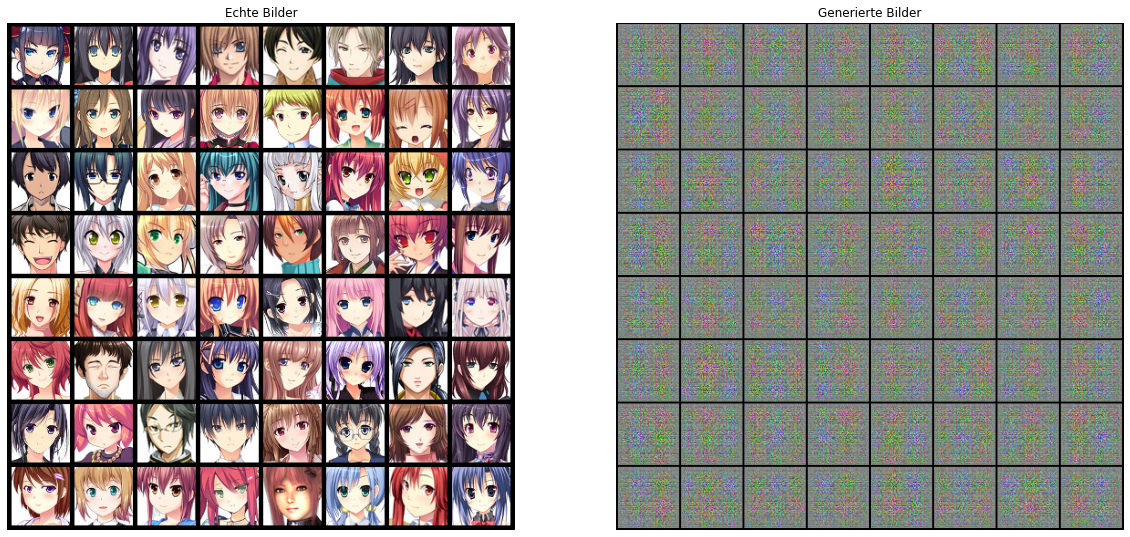

In [27]:
#Direkter Vergleich
real_batch = next(iter(dataloader))
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Echte Bilder")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(dv)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generierte Bilder")
plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))
plt.show()